# Load Time Lapse (Lapse It iOS App) Images and Compare Colors over time

220902 AFRG/RG v1.0
220904 AFRG v1.1
220905 AFRG/RG v2.0 Change so each apple dataset shows picture of region monitored <br>
220905 AFRG/RG v2.1 Continue dataset-based mods above <br>

This version of notebook has some test code - that will not appear in main version

Will need the following more unusual packages
Jupyter, QT6, Pillow (PIL)

## Setup including interactive render environment

In [141]:
import matplotlib
# Want interactive plot
# matplotlib.use('Qt5Agg') # Error - need additional install?
#matplotlib.use('module://backend_interagg') # ModuleNotFoundError: No module named 'backend_interagg'
matplotlib.use('QtAgg')
# matplotlib.use('Qt6') # Shows list of backends
# matplotlib.use('MacOSX') # No figure appears inline
import matplotlib.pyplot as plt
import matplotlib.widgets as widgets

from PIL import Image,ImageOps,ImageDraw,ImageFont   # https://pillow.readthedocs.io/en/stable/installation.html
# font = ImageFont.load_default()
font18 = ImageFont.truetype(r'Arial.ttf', 18) # On MacOS finds font

import numpy as np

import os

# from packaging import version
# version.parse(Image.PILLOW_VERSION)    # https://stackoverflow.com/questions/24688802/saving-an-animated-gif-in-pillow

# Which machine are you running on
#import socket
#socket.gethostname()

# Which user - use for iCloud mount
username = os.environ.get("USER")  # Looking for gaitskel or Araminta
print(username)

gaitskel


### Useful Functions

In [2]:
# List all files in a directory matching dataType
def createImageList( directory , dataType ):
    # directory = path + dataFolder + dataFolderType
    try:
        imageList = np.array( sorted(os.listdir( directory )) )
        imageList = imageList[ [ ("."+dataType) in x  for x in imageList]  ]
        return( imageList )
    except Exception as exc:
        print('Unable to load new filelist\n{exc}')
        return( [] )

In [3]:
# Method callout for animating a user selected click-and-drag rectangle in a figure
def onselect(eclick, erelease):
    if eclick.ydata>erelease.ydata:
        eclick.ydata,erelease.ydata = erelease.ydata,eclick.ydata
    if eclick.xdata>erelease.xdata:
        eclick.xdata,erelease.xdata = erelease.xdata,eclick.xdata
    ax.set_ylim(erelease.ydata,eclick.ydata)
    ax.set_xlim(eclick.xdata,erelease.xdata)
    fig.canvas.draw()

## Load datasets

Create a class that can be used to store a given Apple's evolution

In [345]:
class AppleRegion:
    def __init__(self, dataFolder='', dataFolderType='' , dataType='jpg' , dataPath=()
                 , rectangle=()
                 , appletitle='' , appledescription='' , regiondescription=''
                 , citricconc=0.
                 ):
        self.dataFolder = dataFolder
        self.dataFolderType = dataFolderType
        self.dataType = dataType
        self.imageList = self.createImageList( path + dataFolder + dataFolderType , dataType )
        self.imageLabel = [ x[:-4] for x in self.imageList ] # Drop extension
        self.appletitle = appletitle
        self.appledescription = appledescription
        self.regiondescription = regiondescription
        self.rectangle = rectangle
        if (dataPath): self.dataPath = dataPath
        else: self.dataPath = path
        self.rgb_mean = [] # Save later
        self.citricconc = citricconc

    def __repr__(self):
        return( f"dataset:{self.dataFolder} appletitle:{self.appletitle} rect:{self.rectangle}" )

    def __str__(self):
        return( f"dataset:{self.dataFolder} appletitle:{self.appletitle} rect:{self.rectangle}" )

    def getrectangle(self):
        return( self.rectangle )

    def image(self,n=0): # Scalar argument
        img = Image.open( self.dataPath + self.dataFolder +'/'+ self.dataFolderType +'/'+ self.imageList[n] )  # .crop((left, top, right, bottom))
        return( img )

    def images(self
        , n = ()        # List of indices for limits, default is all
        , addRectangle = True    # Add white rectangle
        , rectangle = ()         # (left, top, right, bottom) - use objectes default if you don't provide values
        , crop = False           # crop based on box
        , addLabel = True        # Add a label
        ):

        if isinstance(n,int):
            flagList = False  # Return a single scalar
            n = [n,]
        else:
            if len(n)<1 :
                n = list( range( len(self.imageList) ) )
            flagList = True

        if not(rectangle):
            rectangle = self.rectangle # Bounds for object

        imgs = [] # return an array of images
        for ii in n:
            img = self.image(ii)
            if crop:
                img = img.crop(rectangle)
            else:
                if addRectangle:
                    img = self.image_add_rectangle( img , rectangle=rectangle )
            if addLabel:
                img = self.image_add_label( img , ii )
            imgs.append( img )

        if not(flagList): imgs = imgs[0]
        return( imgs )

    def image_add_label(self
        , img # image
        , index # index in series for text label
        ):
        img = img.convert("RGBA") # Change to include Alpha
        draw = ImageDraw.Draw(img, "RGBA") # Make linked draw object
        draw.text(
            xy=(3,3)
            , text= self.dataFolder+'\n'+self.imageLabel[index]+'\n'+self.appletitle
            , align='left' , font = font18 ) # fill=color font= ,
        img = img.convert("RGB")  # Remove alpha for displaying
        return( img )

    def image_add_rectangle(self
        ,img
        ,rectangle=( )        # (left, top, right, bottom)
        ):
        if not(rectangle): # If box is empty
            rectangle = ( 0,0,img.size[0],img.size[1] ) # Size of image - no effect
        img = img.convert("RGBA") # Change to include Alpha
        draw = ImageDraw.Draw(img, "RGBA") # Make linked draw object
        (left, top, right, bottom) = rectangle
        draw.rectangle(((left, top), (right, bottom)))  # Adds rectangle with white edge,   ((llx, lly), (urx, ury)) ((left, top), (right, bottom))
        img = img.convert("RGB")  # Remove alpha for displaying
        return( img )


    def save_gifs(self):
        # Save all files in a single animated gif
        (self.images(0)).save( self.dataPath + self.dataFolder + '/'+ self.dataFolder + self.appletitle + "_animated_all.gif"
                       , save_all = True
                       , append_images = self.images( ) # slice(1,-1)
                       , duration = 100
                       , loop = 0
                       )

        # Save first and last files in a single animated gif
        (self.images(0)).save( self.dataPath + self.dataFolder + '/'+ self.dataFolder + self.appletitle + "_animated_first_and_last.gif"
                   , save_all = True
                   , append_images = [self.images(-1)]
                   , duration = 500
                   , loop = 0
                   )

        print(f"Saved gifs in {self.dataPath + self.dataFolder + '/'}")


    def createImageList( self
         , directory
         , dataType
         ):
        # directory = path + dataFolder + dataFolderType
        try:
            imageList = np.array( sorted(os.listdir( directory )) )
            cut2 = [ (".icloud" in x)  for x in imageList]
            cut = [ ("."+dataType) in x  for x in imageList]
            if np.any( np.bitwise_and(cut,cut2) ):  # Is the file .icloud ?
                print( f"Datafiles are not fully sync'd \n{directory}" )
                for i in imageList[ cut ]:
                    print( i )
            imageList = imageList[ cut  ]  # Select only file matching
            return( imageList )
        except Exception as exc:
            print( f'Unable to load new filelist\n{directory}\n{exc}\n' )
            return( [] )


    def set_rgb_mean( self , rgb_mean ):
        self.rgb_mean = rgb_mean




In [346]:
apple = []

# SET 0
#(0)
apple.append(AppleRegion(
    dataFolder = '20220904_151732'  # 3 Apples - 2 Red, 1 G - no surface treatment
    , rectangle = (110, 222, 332, 568) # (left,top,right,bottom)
    , appletitle = "0#1 Air Control RD"
    , appledescription = "Red Delicious #1 - Use it as control, direct to air" # Most of apple
    , regiondescription = "Most of apple" #
    , citricconc = 0.
))

#(1)
apple.append(AppleRegion(
    dataFolder = '20220904_151732'  # 3 Apples - 2 Red, 1 G - no surface treatment
    , rectangle = (500, 400, 640, 568) #
    , appletitle = "0#2 Air Control RD"
    , appledescription = "Red Delicious #2 - Use it as control, direct to air" # Most of apple
    , regiondescription = "Most of apple" #
    , citricconc = 0.
))

#(2)
apple.append(AppleRegion(
    dataFolder = '20220904_151732'  # 3 Apples - 2 Red, 1 G - no surface treatment
    , rectangle =  (841, 240, 1109, 573)
    , appletitle = "0#3 Air Control Gala" # Most of apple
    , appledescription = "Gala #3 - Use it as control, direct to air" # Most of apple
    , regiondescription = "Most of apple" #
    , citricconc = 0.
))

#(3)
apple.append(AppleRegion(
    dataFolder = '20220904_151732'   # 3 Apples - 2 Red, 1 G - no surface treatment
    , rectangle = (366, 593, 505, 707)
    , appletitle = "0#4 Control Paper" # Lower paper
    , appledescription = "Paper - Use it as control of neutral" # Most of apple
    , regiondescription = "Paper at bottom" #
    , citricconc = 0.
))


# SET 1 - # 3 Apples - Citric Acid #1 most concentrated 10 g 10ml, x1/5, x1/5 #3 least
#(4)
# 1#1
apple.append(AppleRegion(
    dataFolder = '20220904_191032'
    , rectangle = (30, 302, 163, 519)
    , appletitle = "1#1 Citric 1g/1ml RD" #
    , appledescription = "Red Delicious - Citric 10g/10ml"
    , regiondescription = "Most of apple" #
    , citricconc = 10. /10. # 10 g / 10 ml
))

#(5)
# 1#2
apple.append(AppleRegion(
    dataFolder = '20220904_191032'
    , rectangle = (478, 373, 640, 585)  #
    , appletitle = "1#2 Citric 1g/5ml RD" #
    , appledescription = "Red Delicious - Citric 5g/25ml"
    , regiondescription = "Most of apple" #
    , citricconc = 5./25.
))

#(6)
# 1#3
apple.append(AppleRegion(
    dataFolder = '20220904_191032'
    , rectangle = (849, 411, 1083, 560)
    , appletitle = "1#3 Citric 1g/25ml RD" #
    , appledescription = "Red Delicious - Citric 5g/125ml"
    , regiondescription = "Most of apple" #
    , citricconc = 5./125.
))


# SET 2
#(7)
# 2#1
apple.append(AppleRegion(
    dataFolder = '20220904_204042'
    , rectangle = (30, 302, 163, 519) #
    , appletitle = "2#1 Water shaken off RD" #
    , appledescription = "Red Delicious - Water"
    , regiondescription = "Most of apple" #
    , citricconc = 0.
))

#(8)
# 2#2
apple.append(AppleRegion(
    dataFolder = '20220904_204042'
    , rectangle = (512, 466, 715, 589)  #
    , appletitle = "2#2 Water left on RD" #
    , appledescription = "Red Delicious - Water"
    , regiondescription = "Most of apple" #
    , citricconc = 5./25.
))

#(9)
# 2#3
apple.append(AppleRegion(
    dataFolder = '20220904_204042'
    , rectangle = (916, 348, 1201, 520) #
    , appletitle = "2#3 Citric 1g/300ml RD" #
    , appledescription = "Red Delicious - Citric"
    , regiondescription = "Most of apple" #
    , citricconc = 1./300.
))



# SET 3
#(10)
# 3#1
apple.append(AppleRegion(
    dataFolder = '20220905_133535'
    , rectangle = (30, 302, 163, 519) #
    , appletitle = "3#1 Citric 1g/50ml RD" #
    , appledescription = "Red Delicious - Citric"
    , regiondescription = "Most of apple" #
    , citricconc = 1./50.
))

#(11)
# 3#2
apple.append(AppleRegion(
    dataFolder = '20220905_133535'
    , rectangle = (480, 265, 719, 489)  #
    , appletitle = "3#2 Citric 1g/100ml RD" #
    , appledescription = "Red Delicious - Citric"
    , regiondescription = "Most of apple" #
    , citricconc = 1./100.
))

#(12)
# 3#3
apple.append(AppleRegion(
    dataFolder = '20220905_133535'
    , rectangle = (885, 381, 1129, 530) # Need to SET
    , appletitle = "3#3 Citric 1g/200ml RD" #
    , appledescription = "Red Delicious - Citric"
    , regiondescription = "Most of apple" #
    , citricconc = 1./200.
))

# dataFolder = '20220904_204042/' # 3 Apples - (1) Water shaken off, (2) (3) 1g Citric, 300 ml water added 2.5 ml

3#3 Citric 1g/200ml RD 20220905_133535 Red Delicious - Citric


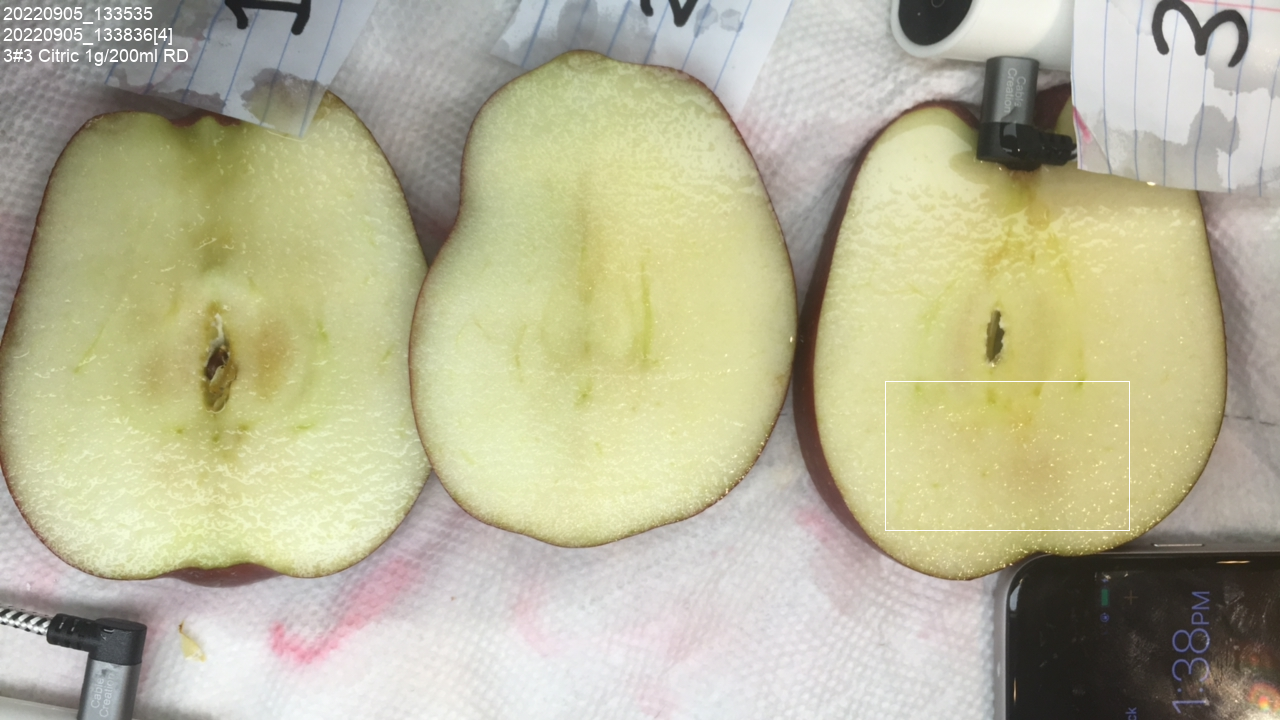

In [328]:
a = apple[12]
print( a.appletitle , a.dataFolder , a.appledescription )
a.images(0)

In [314]:
# Crop image using mouse drag of rectangle
fig = plt.figure()
ax = fig.add_subplot(111)
print( a.dataFolder , a.appletitle , a.appledescription )
im = a.image()
arr = np.asarray(im)
plt_image = plt.imshow(arr)
rs = widgets.RectangleSelector(
    ax
    , onselect=onselect
    , props = dict(facecolor='red', edgecolor = 'black', alpha=0.5, fill=True)
    # , drawtype='box'
    )
    # rectprops = dict(facecolor='red', edgecolor = 'black', alpha=0.5, fill=True))
plt.show()

# print('Rectangle')
# print([ [ f'{x:.0f}' for x in y ] for y in rs.corners ])

# Define image from dragged rectangle in previous image
left = np.min(rs.corners[0]).astype(int)
right = np.max(rs.corners[0]).astype(int)
top = np.min(rs.corners[1]).astype(int)
bottom = np.max(rs.corners[1]).astype(int)

print( (left,top,right,bottom) )

20220905_133535 3#3 Citric 1g/200ml RD Red Delicious - Citric
(885, 381, 1129, 530)


In [347]:
print( apple[0] )
apple[0].save_gifs()
#apple[0].images(-1)

dataset:20220904_151732 appletitle:0#1 Air Control RD rect:(110, 222, 332, 568)
Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_151732/


In [251]:
for a in apple:
    print( a )
    a.save_gifs()

Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_151732/
dataset:20220904_151732 appletitle:G#1 Control rect:(841, 240, 1109, 573)
Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_151732/
dataset:20220904_151732 appletitle:Paper Control rect:(366, 593, 505, 707)
Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_151732/
dataset:20220904_191032 appletitle:RD#2 Citric x3 rect:(849, 411, 1083, 560)
Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_191032/
dataset:20220904_191032 appletitle:RD#3 Water or Citric rect:(30, 302, 163, 519)
Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_191032/
dataset:20220904_151732 appletitle:RD#1 Control rect:(110, 222, 332, 568)
Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_151732/
dataset:20220904_151732 appletitle:G#1 Control rect:(841, 240, 1109

In [ ]:
a = apple[3]
print( a.dataFolder , a.appletitle , a.appledescription )
a.images(0)

In [ ]:
[ display( ii ) for ii in (apple[0].images([0,1,2],crop=False)) ];

In [250]:
apple[0].save_gifs()

Saved gifs in /Users/gaitskel/Library/Mobile Documents/com~apple~CloudDocs/20220904_151732/


In [252]:
# Save the data
import pickle

if 1:
    # Saving the objects:
    with open('apple.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(apple, f)

if 0:
    # Getting back the objects:
    with open('apple.pkl','rb') as f:  # Python 3: open(..., 'rb')
        apple = pickle.load(f)

In [355]:
for a in apple:
    print( a.dataFolder , a.appletitle , a.appledescription )
    rgb_mean = np.zeros( shape=(len(a.imageList),5) )
    for ii,imc in enumerate( a.images(crop=True) ):
        arr = np.asarray(imc)
        # print( f"Image :{ii}")
        rgb_mean[ii,:] = [ii
                , np.mean(arr[:,:,0]),np.mean(arr[:,:,1]),np.mean(arr[:,:,2])
             , (np.mean(arr[:,:,0])+np.mean(arr[:,:,1])+np.mean(arr[:,:,2]))/(3.*2.55) ]
        if 0:
            print(
               f"Image :{ii} Red:{np.mean(arr[:,:,0]):.2f}, Blue:{np.mean(arr[:,:,1]):.2f}, Green:{np.mean(arr[:,:,2]):.2f}"
            )

    if a.dataFolder == '20220905_133535':
        print(f"Correcting {dataFolder}")
        # 20220905_133535   - files start at [04] (first 3 have issues)
        # Apply correction for light shift in 3#1,2,3 in the whte totla >=26, +0.85
        cut = rgb_mean[:,0] >= 26
        rgb_mean[cut ,4] = rgb_mean[cut ,4] - 0.85

    if a.dataFolder == '20220904_191032':
        print(f"Correcting {dataFolder}")
        cut = rgb_mean[:,0] >= 21
        rgb_mean[cut ,4] = rgb_mean[cut ,4] - 0.25

    a.set_rgb_mean( np.array( rgb_mean ) ) # , dtype=object )

20220904_151732 0#1 Air Control RD Red Delicious #1 - Use it as control, direct to air
20220904_151732 0#2 Air Control RD Red Delicious #2 - Use it as control, direct to air
20220904_151732 0#3 Air Control Gala Gala #3 - Use it as control, direct to air
20220904_151732 0#4 Control Paper Paper - Use it as control of neutral
20220904_191032 1#1 Citric 1g/1ml RD Red Delicious - Citric 10g/10ml
Correcting 20220904_204042/
20220904_191032 1#2 Citric 1g/5ml RD Red Delicious - Citric 5g/25ml
Correcting 20220904_204042/
20220904_191032 1#3 Citric 1g/25ml RD Red Delicious - Citric 5g/125ml
Correcting 20220904_204042/
20220904_204042 2#1 Water shaken off RD Red Delicious - Water
20220904_204042 2#2 Water left on RD Red Delicious - Water
20220904_204042 2#3 Citric 1g/300ml RD Red Delicious - Citric
20220905_133535 3#1 Citric 1g/50ml RD Red Delicious - Citric
Correcting 20220904_204042/
20220905_133535 3#2 Citric 1g/100ml RD Red Delicious - Citric
Correcting 20220904_204042/
20220905_133535 3#3 Ci

In [357]:
fig = plt.figure()
ax = fig.add_subplot(111)

for a in apple:

    if 'Citric' in a.appletitle:
        s = '-'
    else:
        s = '--' # water and controls

    ax.plot( a.rgb_mean[:,0]
            , a.rgb_mean[:,4]
            #, 100. * a.rgb_mean[:,4] / a.rgb_mean[0,4]
            , label = a.appletitle
            , linestyle = s
            , linewidth = 3
             )
ax.legend()
ax.set_xlabel('Time [mins]')
ax.set_ylabel('White % [Higher is Brighter]')
ax.grid( True )
ax.set_xlim( -5 , 80 )
plt.title( "Apple Slices - White Light Levels (AFRG)" )
# plt.savefig(  path + dataFolder + dataFolderType + imageList[0][:-4]+" "+target+"_White.png" )
plt.show( )

### Load dataset - select manually

In [ ]:
# Local storage of images in project directory for testing
if 0:
    path = 'data/'
    dataFolder = '20220903_205057-raw_format_example_can_delete/'
    dataFolderType = 'jpg/'
    dataType = 'jpg'

### Load new dataset

in order to indentify a box region to monitor

In [4]:
if 1: # Cloud based data

    # Default values
    path = '/Users/'+username+'/Library/Mobile Documents/com~apple~CloudDocs/'
    dataFolderType = ''
    dataType = 'jpg'

    match 1:
        case 1:
            dataFolder = '20220904_204042/' # 3 Apples - (1) Water shaken off, (2) (3) 1g Citric, 300 ml water added 2.5 ml


### Load previous dataset including box to monitor

In [19]:
# Reference datasets based on the datetime of folder "dataFolder"
# This will be earlier than the first good picture dateStamp used sometimes

if 1: # Cloud based data

    # Default values
    path = '/Users/'+username+'/Library/Mobile Documents/com~apple~CloudDocs/'
    dataFolderType = ''
    dataType = 'jpg'

    match 4:
        case 1:
        case 2:
            dataFolder = '20220904_151732/' # 3 Apples - 2 Red, 1 G - no surface treatment
    target = "RD#1 Control" # Most of apple
    (left,top,right,bottom) = (110, 222, 332, 568)
        case
            dataFolder = '20220904_151732/' # 3 Apples - 2 Red, 1 G - no surface treatment
    target = "G#1 Control" # Most of apple
    (left,top,right,bottom) = (841, 240, 1109, 573)

        case
            dataFolder = '20220904_151732/' # 3 Apples - 2 Red, 1 G - no surface treatment
    target = "Paper Control" # Lower paper
    (left,top,right,bottom) = (366, 593, 505, 707)


        case 3:
            dataFolder = '20220904_191032/' # 3 Apples - Citric Acid #1 most concentrated 10 g 10ml, x1/5, x1/5 #3 least
                target = "RD#2 Citric x3" # Lower paper
    (left,top,right,bottom) = (849, 411, 1083, 560)

        case 3:
            dataFolder = '20220904_191032/' # 3 Apples - Citric Acid #1 most concentrated 10 g 10ml, x1/5, x1/5 #3 least
    target = "RD#3 Water or Citric" # Lower paper
    (left,top,right,bottom) = (30, 302, 163, 519)

        case 4:
            dataFolder = '20220904_204042/' # 3 Apples - (1) Water shaken off, (2) (3) 1g Citric, 300 ml water added 2.5 ml

        case _ :
            print( f"NO DATA SELECTED using {n}")


# Other datasets not used
# dataFolder = '20220904_110525/' # Two Apples as a basic test - moved a little - don't use

In [ ]:
# Load datasets that have been previously selected



### List available files

In [5]:
imageList = createImageList( path + dataFolder + dataFolderType , dataType )
len( imageList )


90

## Set Zoom Range Manually

In [6]:
### Define Region of Image to Monitor - Manually
with Image.open(path + dataFolder + dataFolderType + imageList[0]) as im:
    width, height = im.size
    print((width, height))

# Setting the points for cropped image
if 1:
    left = height * 0
    right = width * 1
    top = height * 0
    bottom = height * 1
if 0:  # Manual select of ROI
    left = width * 3 / 16
    right = width * 13 / 32
    top = height * 5 / 16
    bottom = height * 9 / 16

(1280, 720)


## Show First and Last Images

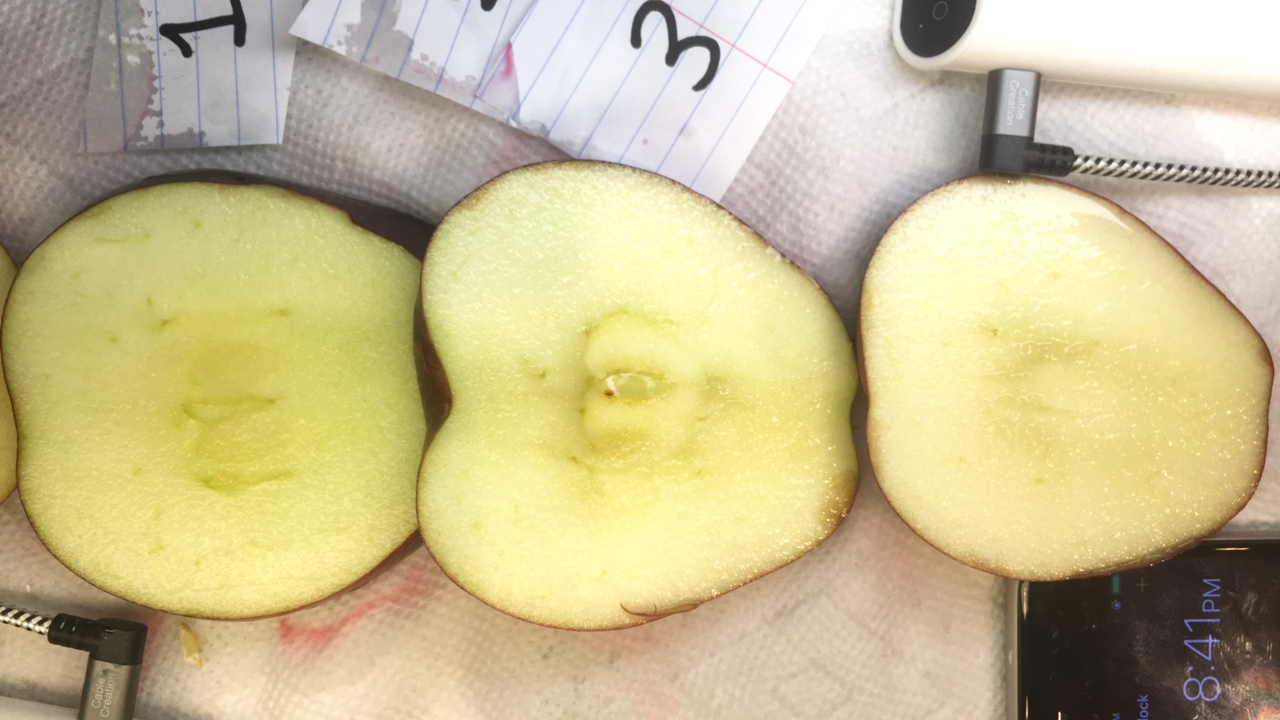

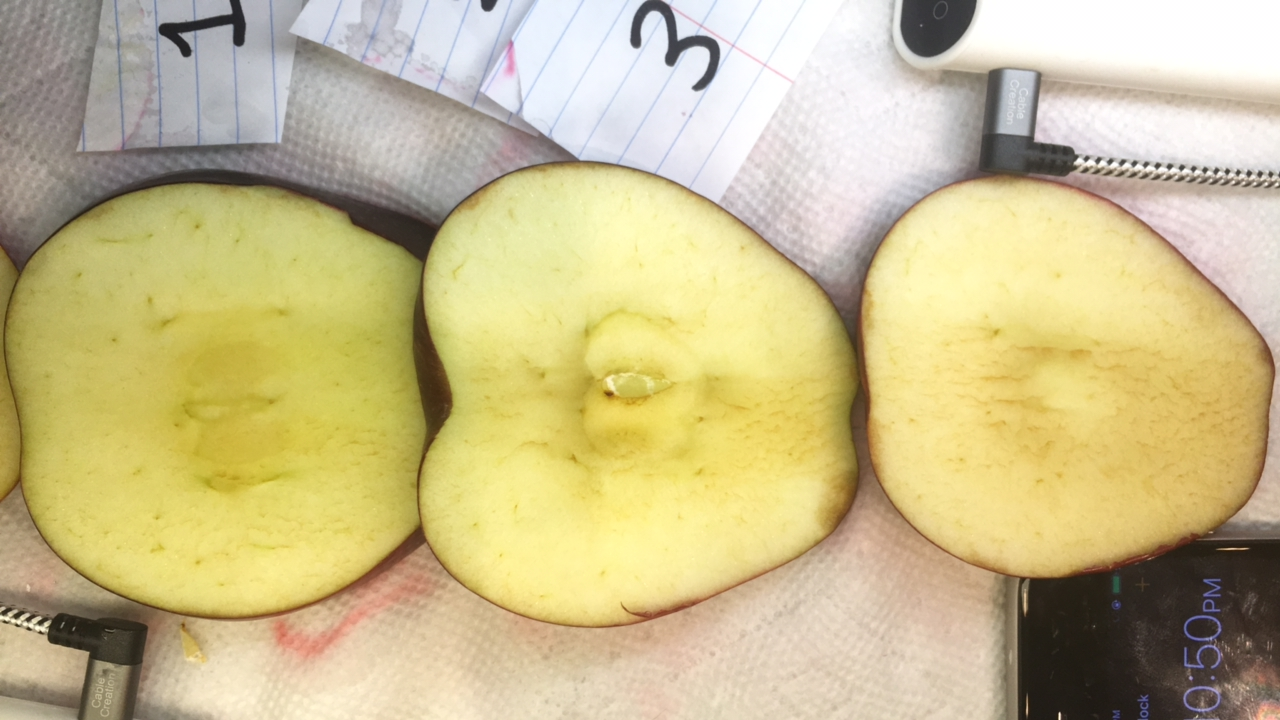

In [7]:
# https://pillow.readthedocs.io/en/stable/reference/Image.html

# Cropped image of above dimension
# (It will not change original image)
# im1 = im.crop((left, top, right, bottom))

for ii in [ imageList[0],imageList[-1]]:
# for ii in imageList[0:5]:
    with Image.open( path + dataFolder + dataFolderType + ii ) as im:
        # im.show() # image appears in MacOS App Preview
        # im.rotate(-90)
        display( im.crop((left, top, right, bottom)) )


## Save GIFs that show animation

## Select Region Manually

In [29]:
# Crop image using mouse drag of rectangle
fig = plt.figure()
ax = fig.add_subplot(111)
# filename="test.png"
filename = path + dataFolder + dataFolderType + imageList[0]
im = Image.open(filename)
arr = np.asarray(im)
plt_image = plt.imshow(arr)
# matplotlib.use('QtAgg') - works
rs = widgets.RectangleSelector(
    ax
    , onselect=onselect
    , props = dict(facecolor='red', edgecolor = 'black', alpha=0.5, fill=True)
    # , drawtype='box'
    )
    # rectprops = dict(facecolor='red', edgecolor = 'black', alpha=0.5, fill=True))
plt.show()

print('Rectangle')
print([ [ f'{x:.0f}' for x in y ] for y in rs.corners ])

Rectangle
[['30', '162', '162', '30'], ['302', '302', '511', '511']]


In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Define image from dragged rectangle in previous image
left = np.min(rs.corners[0]).astype(int)
right = np.max(rs.corners[0]).astype(int)
top = np.min(rs.corners[1]).astype(int)
bottom = np.max(rs.corners[1]).astype(int)
print( (left,top,right,bottom) )

# Show image based on crop
arr = np.asarray(im.crop((left,top,right,bottom)))
plt_image = plt.imshow(arr)
plt.show(  )

(30.467741935483872, 301.6935483870967, 162.0806451612903, 510.7258064516128)


In [31]:
if 1:
    target = "RD#1 Control" # Most of apple
    (left,top,right,bottom) = (110, 222, 332, 568)

if 1:
    target = "G#1 Control" # Most of apple
    (left,top,right,bottom) = (841, 240, 1109, 573)

if 1:
    target = "Paper Control" # Lower paper
    (left,top,right,bottom) = (366, 593, 505, 707)

if 1:
    target = "RD#2 Citric x3" # Lower paper
    (left,top,right,bottom) = (849, 411, 1083, 560)

if 1:
    target = "RD#3 Water or Citric" # Lower paper
    (left,top,right,bottom) = (30, 302, 163, 519)



In [126]:
arr.shape

(346, 222, 3)

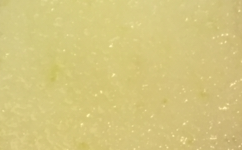

In [12]:
display( im.crop((left,top,right,bottom)) )

In [111]:
arr.shape

(114, 139, 3)

## Try measuring the color of the segment of Apple images

In [33]:
rgb_mean = []

for ii,iim in enumerate( imageList[::1] ):
    with Image.open( path + dataFolder + dataFolderType + iim ) as im:
        # im.show() # image appears in MacOS App Preview
        # im.rotate(-90)


        if 0: # Original Full Image
            imc = im
            display( imc )
        else: # Cropped Image
            imc = im.crop((left, top, right,bottom))

        arr = np.asarray(imc)
        # print( f"Image :{ii}")
        rgb_mean.append(
            [ii, np.mean(arr[:,:,0]),np.mean(arr[:,:,1]),np.mean(arr[:,:,2])]
        )
        print(
           f"Image :{ii} Red:{np.mean(arr[:,:,0]):.2f}, Blue:{np.mean(arr[:,:,1]):.2f}, Green:{np.mean(arr[:,:,2]):.2f}"
        )

        if 0:
            if 1:
                display( imc )
            else: # Blow up the cropped image to see it better
                width,height = imc.size
                display(
                    imc.resize( (width,height) )  # .resize((new_img_width, new_img_height))
                )


        # width, height = im.size
        #display(
        #    imc.resize((width,height))
        #)

rgb_mean = np.array( rgb_mean ) # , dtype=object )

Image :0 Red:208.72, Blue:198.67, Green:111.47
Image :1 Red:208.63, Blue:198.89, Green:110.79
Image :2 Red:208.72, Blue:198.52, Green:109.86
Image :3 Red:208.88, Blue:198.17, Green:109.22
Image :4 Red:208.92, Blue:197.88, Green:108.49
Image :5 Red:208.94, Blue:197.51, Green:107.84
Image :6 Red:208.89, Blue:197.13, Green:107.31
Image :7 Red:208.61, Blue:196.75, Green:106.51
Image :8 Red:208.48, Blue:196.29, Green:105.88
Image :9 Red:208.74, Blue:196.20, Green:105.66
Image :10 Red:208.56, Blue:195.95, Green:105.24
Image :11 Red:208.63, Blue:195.78, Green:104.89
Image :12 Red:208.52, Blue:195.46, Green:104.41
Image :13 Red:208.46, Blue:195.35, Green:104.06
Image :14 Red:208.43, Blue:195.10, Green:103.63
Image :15 Red:208.55, Blue:194.97, Green:103.31
Image :16 Red:208.40, Blue:194.79, Green:103.05
Image :17 Red:208.30, Blue:194.57, Green:102.56
Image :18 Red:208.36, Blue:194.43, Green:102.38
Image :19 Red:208.30, Blue:194.24, Green:102.01
Image :20 Red:208.18, Blue:194.11, Green:101.84
Im

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( rgb_mean[:,0] , rgb_mean[:,1]/2.55 , 'r-' , label='Red')
ax.plot( rgb_mean[:,0] , rgb_mean[:,2]/2.55 , 'g-' , label='Green')
ax.plot( rgb_mean[:,0] , rgb_mean[:,3]/2.55 , 'b-' , label='Blue')
ax.legend()
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Color % [Higher is Brighter]')
ax.grid( True )
plt.title( imageList[0][:-4]+" "+target )
plt.savefig(  path + dataFolder + dataFolderType + imageList[0][:-4]+" "+target+"_RGB.png" )
plt.show( )

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot( rgb_mean[:,0]
         , (rgb_mean[:,1]+rgb_mean[:,2]+rgb_mean[:,3])/(3.*2.55)
         , 'k-' , label='White')
ax.legend()
ax.set_xlabel('Time [mins]')
ax.set_ylabel('Wite % [Higher is Brighter]')
ax.grid( True )

plt.title( imageList[0][:-4]+" "+target )
plt.savefig(  path + dataFolder + dataFolderType + imageList[0][:-4]+" "+target+"_White.png" )
plt.show( )

# Demo Drawing A White Rectangle (Can delete)

In [26]:
 (left,top,right,bottom) = (110, 222, 332, 568)

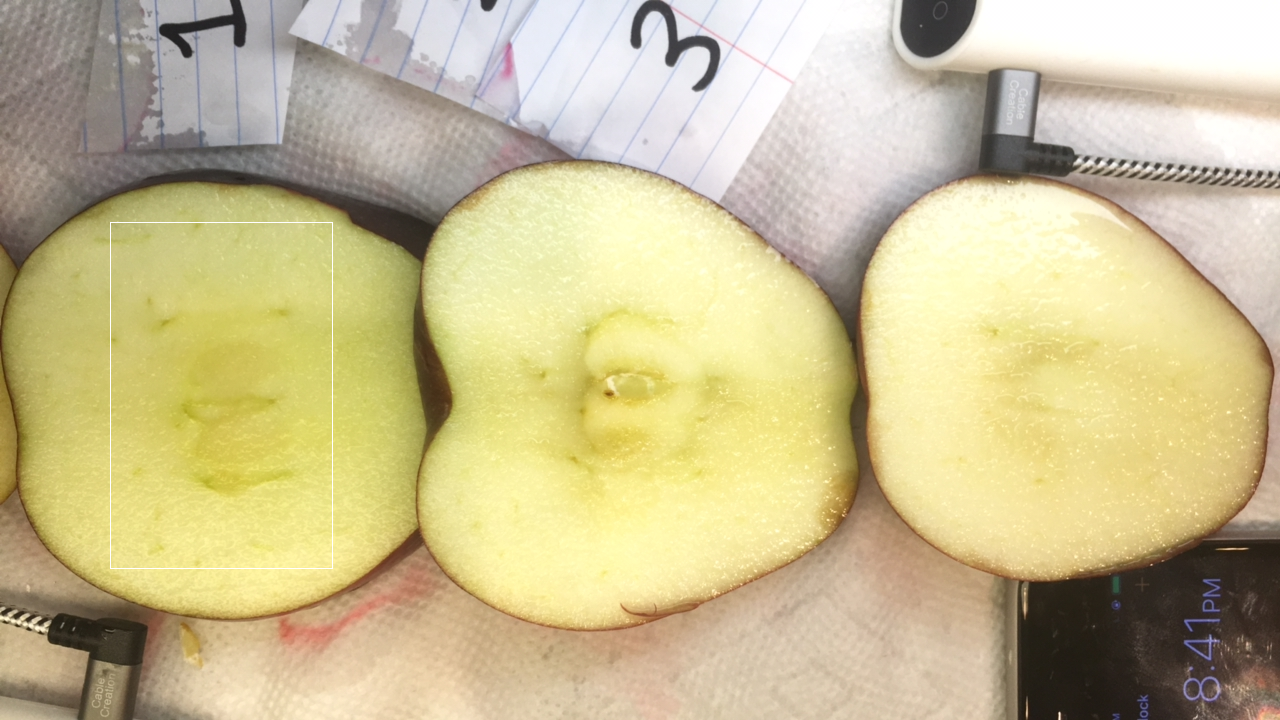

In [31]:
img = Image.open( path + dataFolder + dataFolderType + imageList[0] ) # .crop((left, top, right, bottom))
img = img.convert( "RGBA" )

if 0:
    # This works
    overlay = Image.new('RGBA', img.size, (255,255,255,0) )
    draw = ImageDraw.Draw( overlay )
    draw.rectangle( ((left,top),(right,bottom)) ) # White edge,   ((llx, lly), (urx, ury))   ((50, 100), (200, 300))
    # img.size[0],img.size[1] , fill=(255,0,0,50)
    # Alpha composite these two images together to obtain the desired result.
    img = Image.alpha_composite( img , overlay)
else:
    # This works
    draw = ImageDraw.Draw( img , "RGBA" )
    draw.rectangle( ((left,top),(right,bottom)) ) # White edge,   ((llx, lly), (urx, ury))   ((50, 100), (200, 300))

img = img.convert("RGB") # Remove alpha for displaying

display( img )

In [48]:
x = list(range(10))

def f(n):
    #print( x[n] )
    return( x[n] )


In [50]:
f( slice( 1 ,-1) )

[1, 2, 3, 4, 5, 6, 7, 8]


[1, 2, 3, 4, 5, 6, 7, 8]

In [56]:
f( (0,-1) )

TypeError: list indices must be integers or slices, not tuple

In [57]:
list( 4 )

TypeError: 'int' object is not iterable